**Flood Mapping

To run this notebook, you will need:
1. geojson of your study area (preferably in WGS84). 
    - One place to easily create one is from https://geojson.io/ from MapBox. 
2. config.yaml file. 
    - update it to the file paths/parameters of your choosing. (existing config file in config folder)
3. GeoTIF:
    - Urban settlements present day and for future scenario
4. GeoTIF of MWDWI
    - In this example, used images from 2022-04-05 and 2022-04-17, acquired from the Digital Earth Africa (DEA) sandbox using DEA tools. For the NDFI and MNDWI indices, used Landsat-8 30m image from 14th April 2022

## Background. 

This notebook has been created for G20 DRR Hackathon for Team MapleByte (Canada). This works towards the 'Flood Risk' portion of the challenge.  
Project/team site: [g20hack-maplebyte.climatechange.ca](https://g20hack-maplebyte.climatechange.ca/).

For the NDFI and MNDWI indices I used Landsat-8 30m image from 14th April 2022.

For flood mapping we've broken the task into two components;
1. Current flood and short-term flood extents
2. Longer term flood

Both scenarios are mostly hypothtical. 




In Scenario 1, we combine satellite data and HAND model to estimate flood boundaries. Satellite data was used to identify water. The image used is from 2022-04-14, using LandSat8 and computing MNDWI. This was then thresholded to estimate water and non-water. From the 'water' we then analyzed it with the Height Above Nearest Drainage (HAND) dataset, built from the Copernicus Glo 30 DEM. The intersection of the MNDWI and the associated HAND values was explored and statistics of those HAND values were recorded. We combined this HAND and MNDWI to be a 'current' flood scenario. We then added an artificial adjustment to estimate short-term potential flood. e.g. in the next 24hrs what might the water level change to. 
We then explored vector data from OSM, streets, emergency facilities (hospital, police, firestations, etc.) parks in combination with the flood extents to estimate where probable evacuation points could be for citizens in/near flood zones. 

*for the current and short-term future flood scenarios, using near-by river gauges, synthetic rating curves or manual estimates could aid in creating a more realistic extent map. 

In Scenario 2, we made use of the HAND Model again, setting differnt thresholds for potential future flood extents. These again are hypothetical, but could represent changing flood zones due to climate change, increased urbanization, etc. This is then overlaid by the urban pixels identified in task1, and the estimated growth from task 2. 

### 📦 Standard Library
there is a requirements.txt available
| Module         |
|----------------|
| os             |
| sys            |
| glob           |
| time           |
| shutil         |
| argparse       |
| itertools      |
| statistics     |
| json           |
| zipfile        |
| requests       |
| pathlib (Path) |
| logging (config)|

### 🌍 Third-Party Libraries
| Module / Submodule                                                                 |
|-------------------------------------------------------------------------------------|
| yaml                                                                                |
| numpy (np)                                                                          |
| rasterio (enums, features, transorm, mask, merge, reproject)                        |
| geopandas (gpd)                                                                     |
| shapely.geometry (box, shape, Point, mapping, Polygon, MultiPolygon, LineString)    |
| shapely.ops (unary_union)                                                           |
| matplotlib.pyplot (plt)                                                             |
| fiona                                                                               |
| pyproj.CRS                                                                          ||
| whitebox.whitebox_tools (WhiteboxTools)                                             |
| osmnx (ox)                                                                          |
| pystac_client (Client)                                                              |
| fsspec                                                                              |
| geodatasets                                                                         |
| folium, folium.FeatureGroup, folium.GeoJson, folium.Map, folium.Html, folium.Element|
| branca.colormap (cm)                                                                |


In [1]:
import yaml
import os

# Cell: Visualize DTM and AOI

import os
import yaml
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import folium
from folium import GeoJson
import branca.colormap as cm

In [2]:
import sys, os
sys.path.append("D:/g20/")  # adjust to your project root

In [3]:
# Load Config file: 
import yaml
config_file = "D:/g20/src/config/config.yaml"
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)



## Step 1
####  Get Digital elevation data

The dtm.py script in the dtm folder extracts a Digital Elevation Model (DEM) for a specified area using the Copernicus GLO-30 dataset. It:

Loads a project boundary from a GeoJSON file.
Connects to an Open Data Cube (ODC) instance.
Loads the DEM data for the area of interest at ~30m resolution.
Masks the DEM to the project boundary.
Saves the clipped DEM as a GeoTIFF file.
Uses libraries like os, yaml, geopandas, datacube, rasterio, and numpy.
The script reads configuration from a YAML file and runs the extraction automatically when executed.

In [4]:
#import src.dtm.dtm as dtm
#dtm.main_hydrocondition(config_file)

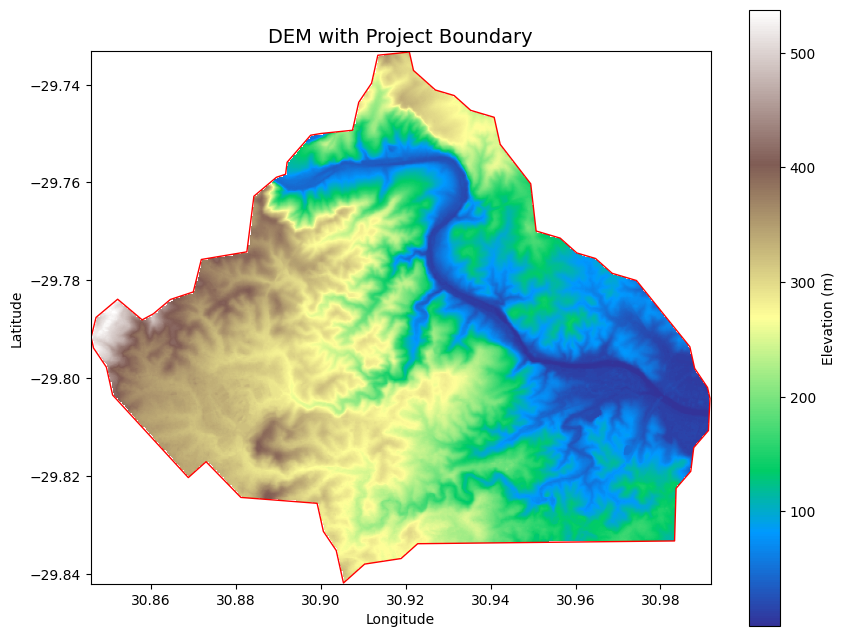

In [5]:
###PLOT RASTER
import os
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show
from shapely.geometry import mapping

raster_path = os.path.join(config['dtm_folder'], "dem_copglo30_clipped.tif")
vector_path = config['projectboundary']

with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    
    # Read raster and replace nodata with NaN
    raster_data = src.read(1).astype(float)
    if src.nodata is not None:
        raster_data[raster_data == src.nodata] = np.nan
    
    # Open vector and reproject
    gdf = gpd.read_file(vector_path).to_crs(raster_crs)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Use imshow manually so NaNs render transparent
    img = ax.imshow(
        raster_data, 
        cmap="terrain", 
        extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top),
        origin="upper"
    )
    plt.colorbar(img, ax=ax, label="Elevation (m)")

    # Overlay vector boundary
    gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=1)

    ax.set_title("DEM with Project Boundary", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

plt.show()

## Hydro condition elevation model

The hydrocondition.py script prepares a digital elevation model (DEM) for hydrological analysis and generates a Height Above Nearest Drainage (HAND) raster. 
<p> Steps included in this include: 

- Hydrological Conditioning: Fills pits, depressions, and missing data in the DEM using WhiteboxTools to create a hydrologically conditioned DEM.
- Stream Network Extraction: Calculates flow accumulation, flow direction, and extracts stream networks based on a threshold.
- Stream Ordering & Vectorization: Assigns stream order (Hack, Topological, Horton, or Strahler), reclassifies streams, and converts them to vector format.
- HAND Calculation: Computes the HAND raster, representing elevation above the nearest stream.
- Clipping & Masking: Clips rasters to the study area boundary and ensures correct spatial reference.
- Utility Functions: Includes helpers for saving CRS, extracting stream endpoints, quantile calculations, and mosaicking/clipping rasters.
- Workflow: The main_hydrocondition function orchestrates the above steps using configuration from a YAML file.

For details on tHAND model, some publications include: https://www.sciencedirect.com/science/article/pii/S003442570800120X, 


In [ ]:
import src.dtmprocessing.hydrocondition as hydro
hydro.main_hydrocondition(config)


.\whitebox_tools.exe --run="FillMissingData" --wd="D:\g20\durban" --input='D:/g20/durban/dtm/dem_copglo30_clipped.tif' --output='fillnas.tif' --filter=11 --weight=0.5 --no_edges -v --compress_rasters=False



## Exposure 

This script downloads and saves OpenStreetMap (OSM) data for a given area of interest (AOI) defined by a GeoJSON file. It:

- Loads the AOI boundary and ensures it is in the correct coordinate system.
- Downloads three types of OSM data within the AOI:
- Streets (roads and highways)
- Facilities (hospitals, clinics, police, fire stations, etc.)
- Parks/Greenspaces (parks, gardens, playgrounds, etc.)

- Saves each dataset as a GeoJSON file in a specified output folder.
    - Prints a message if no features are found for any category.

<p>In short, it automates the extraction of key infrastructure and greenspace data from OSM for a project area.

In [ ]:
import exposure.osmdata as osm_main
osm_main.main_osmdata(config)

SSLError: HTTPSConnectionPool(host='overpass-api.de', port=443): Max retries exceeded with url: /api/interpreter (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1000)')))

## Flood Map

This section processes geospatial raster data to help map flood risk using satellite and elevation data. 
<p>In brief: The script takes satellite and elevation data, identifies current and potential future flooded areas, and saves new raster files showing these flood extents. It also outputs statistics about the flooded areas for further analysis 

- Reclassifies a satellite raster (A): 
    - It loads a raster (like an MNDWI water index image), and marks pixels as “1” if they are below a certain threshold (indicating water), and as “nodata” otherwise. This creates a binary water mask.
-Masks a HAND raster (B) using the water mask:
    - It aligns the water mask with a HAND (Height Above Nearest Drainage) raster and keeps HAND values only where the water mask is “1”. All other pixels are set to nodata.

- Computes statistics:
    -Calculates the minimum, maximum, mean, and median of the HAND values in the flooded (water) areas.

- Creates a flood scenario raster:
    - Creates a new raster where only HAND values less than or equal to the median are kept (representing a plausible flood extent), and all others are set to nodata.

- Creates a short-term future flood scenario:
    - It increases the flood threshold by a configurable amount and repeats the masking process to simulate a possible near-future flood.



In [ ]:
import risk.hybridHAND as floodmap
floodmap.main_floodmapping(config)

Saved: D:/g20/durban/risk/SVreclass_raster.tif
reclass_src.read(1) shape: (701, 1891)
reclass_data shape: (392, 526)
src_transform: | 10.00, 0.00, 2976190.00|
| 0.00,-10.00,-3633790.00|
| 0.00, 0.00, 1.00|
src_crs: EPSG:6933
dst_transform: | 0.00, 0.00, 30.85|
| 0.00,-0.00,-29.73|
| 0.00, 0.00, 1.00|
dst_crs: EPSG:4326
Saved: D:/g20/durban/risk/rasterC.tif
Raster C statistics: {'min': -9999.0, 'max': 320.1025343404541, 'mean': -2941.2796651557082, 'median': 10.329011009765622}
Saved: D:/g20/durban/risk/HAND_raster_Flood.tif


{'min': -9999.0,
 'max': 320.1025343404541,
 'mean': -2941.2796651557082,
 'median': 10.329011009765622}

In [ ]:
#for scenario 2, future flood boundaries
import risk.Futurefloods as ff
ff.risk(config)

Columns: Index(['name', 'name_en', 'building', 'building_l', 'building_m', 'addr_full',
       'addr_house', 'addr_stree', 'addr_city', 'office', 'source', 'name_af',
       'name_nr', 'name_st', 'name_nso', 'name_ssw', 'name_ts', 'name_tn',
       'name_ve', 'name_xh', 'name_zu', 'osm_id', 'osm_type', 'geometry',
       'current_water_depth'],
      dtype='object')
   name name_en building building_l building_m addr_full addr_house  \
0  None    None      yes       None       None      None       None   
1  None    None      yes       None       None      None       None   
2  None    None      yes       None       None      None       None   
3  None    None      yes       None       None      None       None   
4  None    None      yes       None       None      None       None   

  addr_stree addr_city office  ... name_ssw name_ts name_tn name_ve name_xh  \
0       None      None   None  ...     None    None    None    None    None   
1       None      None   None  ...     None   

AttributeError: module 'risk.Futurefloods' has no attribute 'main_futurefloods'

## Evacuation sites

- Find safe areas: It reads a flood map and identifies dry land by converting safe (non-flooded) areas into polygons. split these polygons into 100 individual polygons. 
- Check road access: It keeps only those dry areas that are close enough to roads, making sure people can reach them.
- Filter by elevation: It removes sites that are too low, keeping only those above a certain elevation to avoid future flooding.
- Check proximity to services: It further filters sites to make sure they are near important services like hospitals and parks.
- Score sites: It ranks the remaining sites based on how close they are to these services.
- Save results: The final list of ideal evacuation sites is saved as a GeoJSON file for use in maps or other tools.

In [ ]:
import risk.musterPoints as mp
mp.main_musterpoints(config)


## View map:



In [ ]:
# patch the function to return the map object and save it to html
import visualize.mapShortTerm as mapshort
original = mapshort.create_flood_risk_map
mapshort.create_flood_risk_map = lambda config: (lambda m: (m.save(config['output_html']), m)[1])(original(config))

# now call it
m = mapshort.create_flood_risk_map(config)
m  # display inline in Jupyter

In [ ]:


# patch the function to return the map object and save it to html
import visualize.mapFutureScenario as maplong
original = maplong.create_flood_risk_map
maplong.create_flood_risk_map = lambda config: (lambda m: (m.save(config['output_html']), m)[1])(original(config))

# now call it
m = maplong.create_flood_risk_map(config)
m  # display inline in Jupyter

NameError: name 'config' is not defined